In [1]:
import os
# WARNING: Execute this cell only once !
os.chdir('../')

In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
import numpy as np
import torch

/Users/fermanian/.conda/envs/sigenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Plots requirements

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

sns.set_style('whitegrid')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

sns.set_palette('colorblind')

color_palette = sns.color_palette("colorblind")

In [5]:
from src.datagen import create_X, get_train_val_test, TumorGrowth
from src.models import SigLasso, GRUModel, NeuralCDE
from src.sampling import downsample
from src.utils import get_cumulative_moving_sum, fill_forward, l2_distance, mse_on_grid, normalize_path
from src.train import train_gru, train_neural_cde

In [6]:
# from experiments.configs import grid_n_points_Y

# Generate and downsample data

In [60]:
model_X = 'brownian'
model_Y = 'ornstein_uhlenbeck'

n_points_true = 500

dim_X = 2
dim_Y = 1
# non_linearity_Y = 'Tanh'

n_train = n_test = n_val = 100

In [61]:
X_raw_train, Y_raw_train, X_raw_val, Y_raw_val, X_raw_test, Y_raw_test = get_train_val_test(
    model_X,
    model_Y, 
    n_train, 
    n_val, 
    n_test,
    n_points_true,
    dim_X=dim_X, 
    dim_Y=dim_Y,
#     non_linearity_Y=non_linearity_Y
)

In [62]:
print(f'X_raw_train shape: {X_raw_train.shape}, Y_raw_train shape: {Y_raw_train.shape}')

X_raw_train shape: torch.Size([100, 500, 2]), Y_raw_train shape: torch.Size([100, 500, 1])


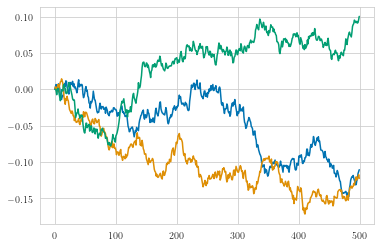

In [63]:
plt.plot(X_raw_train[:3, :, 1].T)
plt.show()

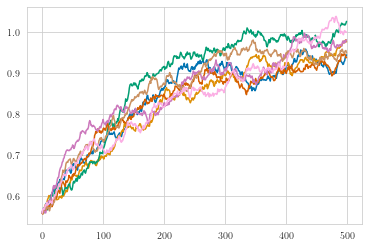

In [64]:
plt.plot(Y_raw_train[:7, :, 0].T)
plt.show()

In [90]:
n_points_Y = 4
n_points_X = 100

In [91]:
X_train, grid_X_train = downsample(
        X_raw_train, n_points_X, keep_first=True, keep_last=True)
Y_train, grid_Y_train = downsample(
        Y_raw_train, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_train)

X_val, grid_X_val = downsample(
        X_raw_val, n_points_X, keep_first=True, keep_last=True)
Y_val, grid_Y_val = downsample(
        Y_raw_val, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_val)

In [92]:
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

X_train shape: torch.Size([100, 102, 2])
Y_train shape: torch.Size([100, 5, 1])


# Model 1:  SigLasso

In [93]:
sig_order = 5

lasso_sig = SigLasso(sig_order, Y_train.shape[2], weighted=True, normalize=True)
lasso_sig.train(X_train, Y_train, grid_Y=grid_Y_train, grid_X=grid_X_train)

In [94]:
Y_train_pred = lasso_sig.predict(X_raw_train)
Y_test_pred = lasso_sig.predict(X_raw_test)

In [95]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test))

# print(f'mse_last_point_train = ', mse_on_grid(Y_train_pred, Y_train, grid_Y=grid_Y_val))
# print(f'mse_last_point_val = ', mse_on_grid(Y_val_pred, Y_val, grid_Y=grid_Y_val))

l2_train =  0.0024110388216337054
l2_test =  0.002435691276645803


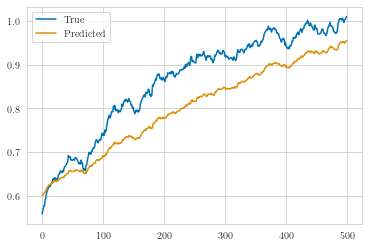

In [96]:
i = 10

plt.plot(np.arange(Y_raw_train.shape[1] ), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()

In [72]:
# print(lasso_sig.reg.intercept_)
# print(lasso_sig.reg.coef_)

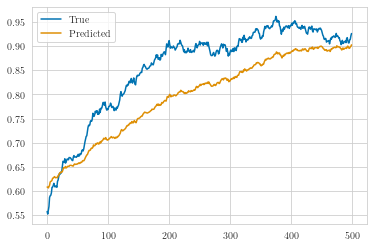

In [73]:
i = 3

plt.plot(np.arange(Y_raw_test.shape[1]), Y_raw_test[i, :, 0], label='True')
plt.plot(np.arange(Y_test_pred.shape[1]), Y_test_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()

In [50]:
# plt.plot(Y_val_pred[0, :, 0], label='pred')
# plt.plot(Y_raw_val[0, :, 0], label='true')
# plt.legend()
# plt.show()

# Model 2 : Neural CDE

In [52]:
n_epochs = 20
ncde_vector_field = 'original'
ncde_lr = 1e-3

ncde_model = NeuralCDE(dim_X, dim_Y, vector_field=ncde_vector_field)

train_neural_cde(ncde_model, X_train, Y_train, n_epochs, grid_Y=grid_Y_train, lr=ncde_lr)

Epoch: 0   Training loss: 0.7485249638557434
Epoch: 1   Training loss: 0.5212194919586182
Epoch: 2   Training loss: 0.34480607509613037
Epoch: 3   Training loss: 0.22050632536411285
Epoch: 4   Training loss: 0.123268723487854
Epoch: 5   Training loss: 0.0646248310804367
Epoch: 6   Training loss: 0.032492782920598984
Epoch: 7   Training loss: 0.0176486037671566
Epoch: 8   Training loss: 0.015198521316051483
Epoch: 9   Training loss: 0.01612856797873974
Epoch: 10   Training loss: 0.01655024290084839
Epoch: 11   Training loss: 0.016281599178910255
Epoch: 12   Training loss: 0.01595458760857582
Epoch: 13   Training loss: 0.01827274076640606
Epoch: 14   Training loss: 0.02044696733355522
Epoch: 15   Training loss: 0.02103458344936371
Epoch: 16   Training loss: 0.022666051983833313
Epoch: 17   Training loss: 0.023238729685544968
Epoch: 18   Training loss: 0.020721066743135452
Epoch: 19   Training loss: 0.02063775435090065


NeuralCDE(
  (func): OriginalVectorField(
    (linear1): Linear(in_features=1, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=2, bias=True)
  )
  (initial): Linear(in_features=2, out_features=1, bias=True)
)

In [53]:
Y_test_pred = ncde_model.predict_trajectory(X_raw_test)
Y_train_pred = ncde_model.predict_trajectory(X_raw_train)

In [54]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test))

l2_train =  0.07209554
l2_test =  0.07241375


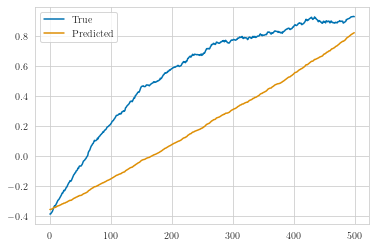

In [55]:
i = 2

plt.plot(np.arange(Y_raw_train.shape[1]), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()

# Model 3 : GRU

In [56]:
gru_hidden_units = 128
gru_lr = 1e-03
n_epochs = 100

gru_model = GRUModel(dim_X, gru_hidden_units, dim_Y)

train_gru(gru_model, X_train, Y_train, n_epochs, grid_Y=grid_Y_train, lr=gru_lr)

Epoch: 0   Training loss: 0.3801182508468628
Epoch: 1   Training loss: 0.2544647455215454
Epoch: 2   Training loss: 0.20206506550312042
Epoch: 3   Training loss: 0.29365038871765137
Epoch: 4   Training loss: 0.213984876871109
Epoch: 5   Training loss: 0.18667538464069366
Epoch: 6   Training loss: 0.1794203519821167
Epoch: 7   Training loss: 0.17437675595283508
Epoch: 8   Training loss: 0.17415796220302582
Epoch: 9   Training loss: 0.17485351860523224
Epoch: 10   Training loss: 0.16280022263526917
Epoch: 11   Training loss: 0.14529049396514893
Epoch: 12   Training loss: 0.13181425631046295
Epoch: 13   Training loss: 0.11970088630914688
Epoch: 14   Training loss: 0.1065405011177063
Epoch: 15   Training loss: 0.08897556364536285
Epoch: 16   Training loss: 0.06970737129449844
Epoch: 17   Training loss: 0.04822402074933052
Epoch: 18   Training loss: 0.028297845274209976
Epoch: 19   Training loss: 0.015679486095905304
Epoch: 20   Training loss: 0.023855801671743393
Epoch: 21   Training loss:

GRUModel(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [57]:
Y_test_pred = gru_model.predict_trajectory(X_raw_test)
Y_train_pred = gru_model.predict_trajectory(X_raw_train)

In [58]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test))

l2_train =  0.13562064
l2_test =  0.13535716


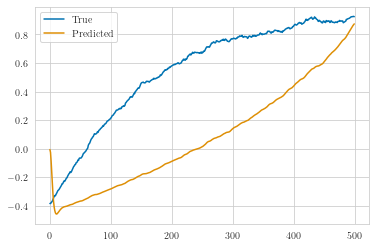

In [59]:
i = 2

plt.plot(np.arange(Y_raw_train.shape[1]), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()